<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Компания такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Необходимые этапы:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor, Pool
import lightgbm as lgb
from sklearn.dummy import DummyRegressor
from sklearn.metrics import make_scorer


## Подготовка

In [2]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Интервал между значениями равен 10 минутам.

In [5]:
#проверим, в хронологическом ли порядке расположены даты и время
df.index.is_monotonic

True

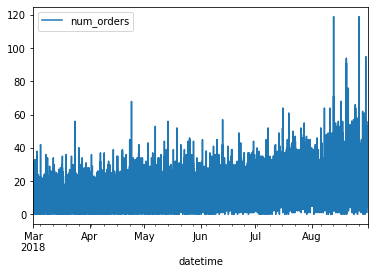

In [6]:
df.plot();

Так мы подгрузили и отобразили данные за период с 01.03.2018 по 31.08.2018 периодичностью в 10 минут.

In [7]:
# выполним ресемплирование
df = df.resample('1H').sum()

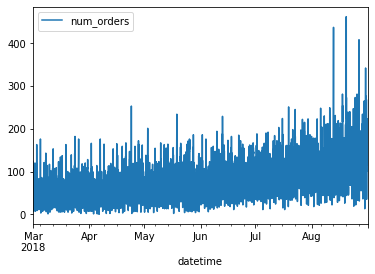

In [8]:
df.plot();

Теперь можем переходить к анализу.

## Анализ

Посмотрим, насколько стационарен наш ряд.

Сперва проводем анализ для ряда, а затем для его разностей, зная, что последние более стационарны, чем сам ряд. После чего сравним результаты. 

In [9]:
df['rolling_mean'] = df['num_orders'].rolling(15).mean()
df['rolling_std'] = df['num_orders'].rolling(15).std()

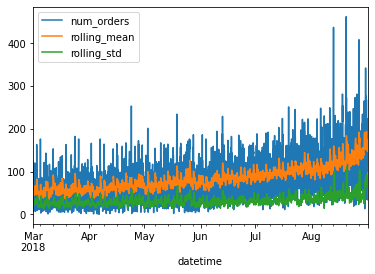

In [10]:
df.plot();

Визуально, можем утверждать, что наш ряд не стацонарный, потому что у него меняется среднее значение. Но это не страшно, ведь мы знаем, что разности временного ряда более стационарны, чем сам ряд, а создававать признаки мы будем на разностях.

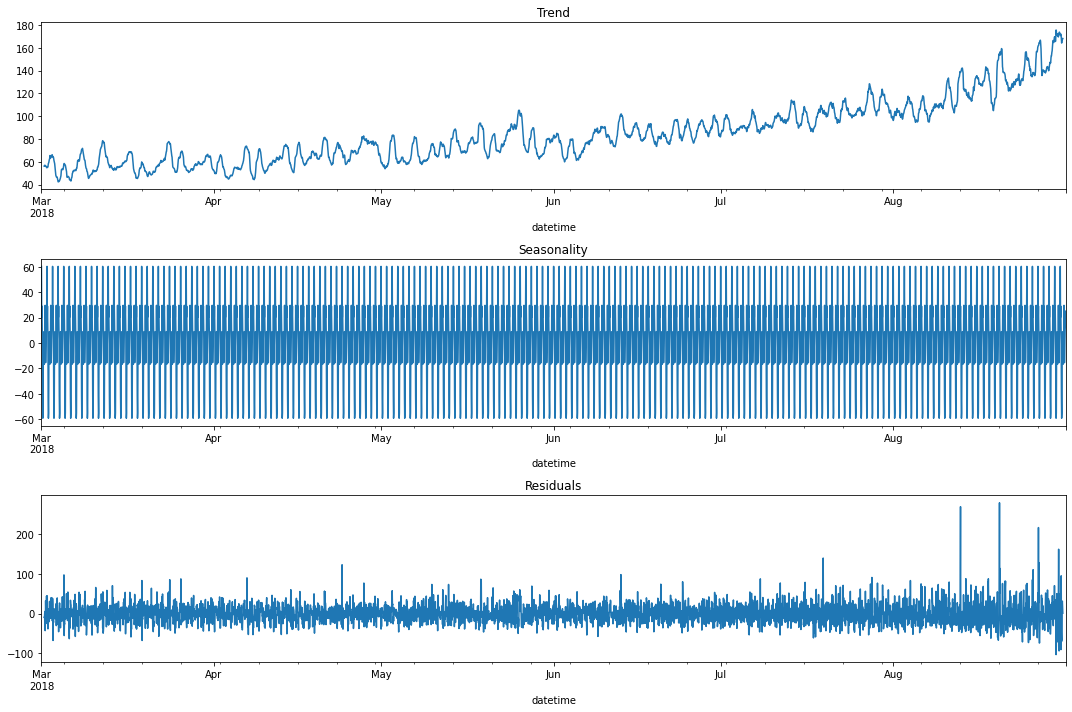

In [11]:
# разложим временной ряд на тренд и сезонную компоненту
decomposed = seasonal_decompose(df['num_orders'])

plt.figure(figsize = (15,10))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

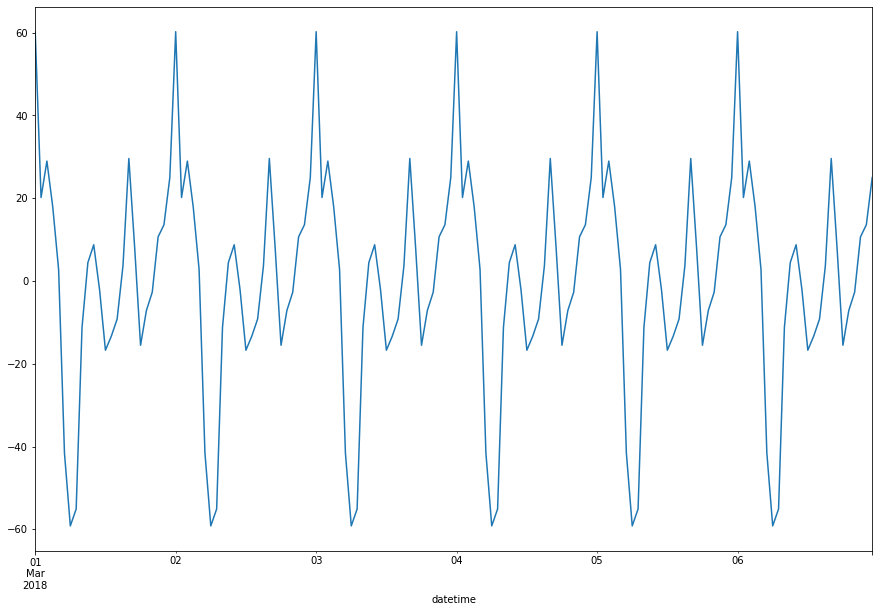

In [12]:
# посмторим на сезонность на отрезке в календарную неделю
decomposed.seasonal['2018-03-01':'2018-03-6'].plot(ax=plt.gca(), figsize = (15,10));

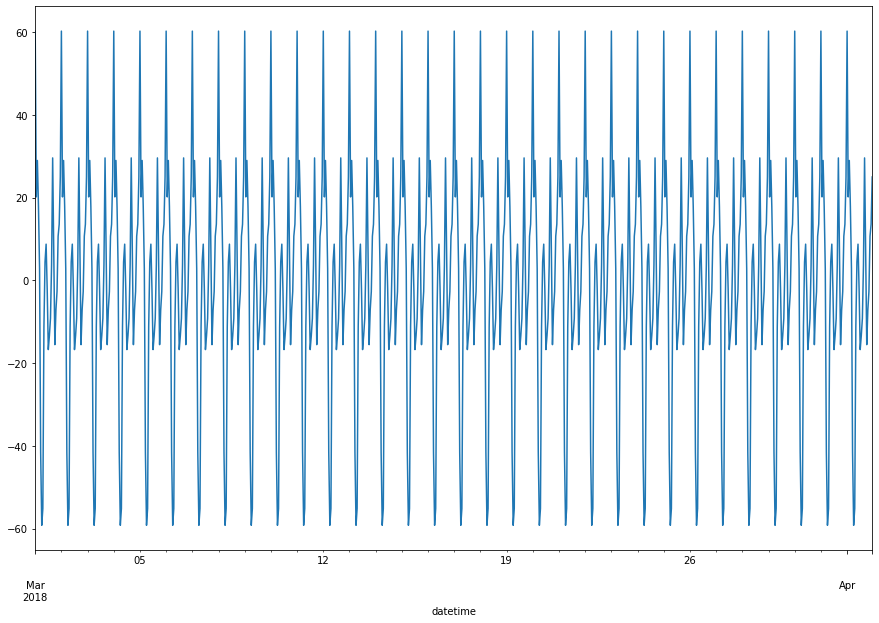

In [13]:
# посмторим на сезонность на отрезке в календарную неделю
decomposed.seasonal['2018-03-01':'2018-04-01'].plot(ax=plt.gca(), figsize = (15,10));

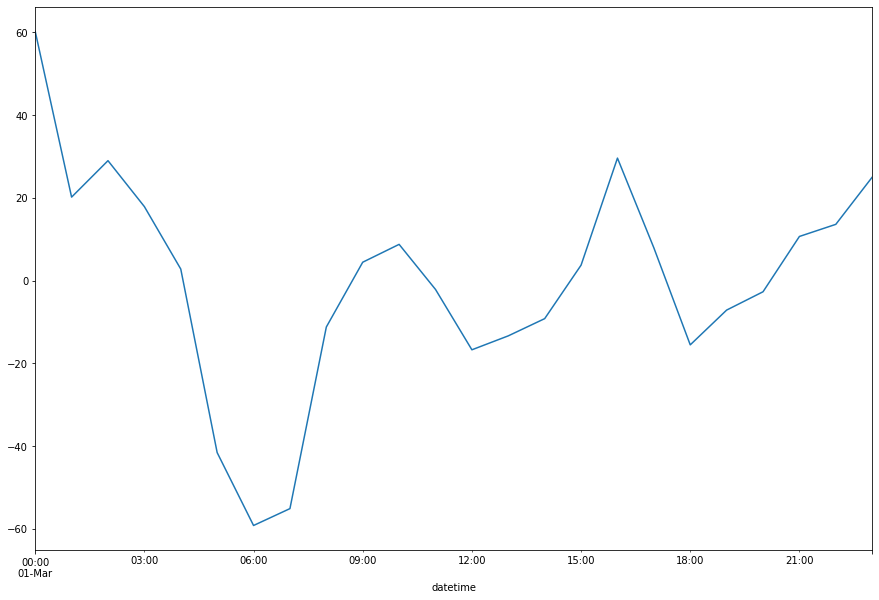

In [14]:
# посмторим на сезонность на отрезке в один день
decomposed.seasonal['2018-03-01':'2018-03-1'].plot(ax=plt.gca(), figsize = (15,10));

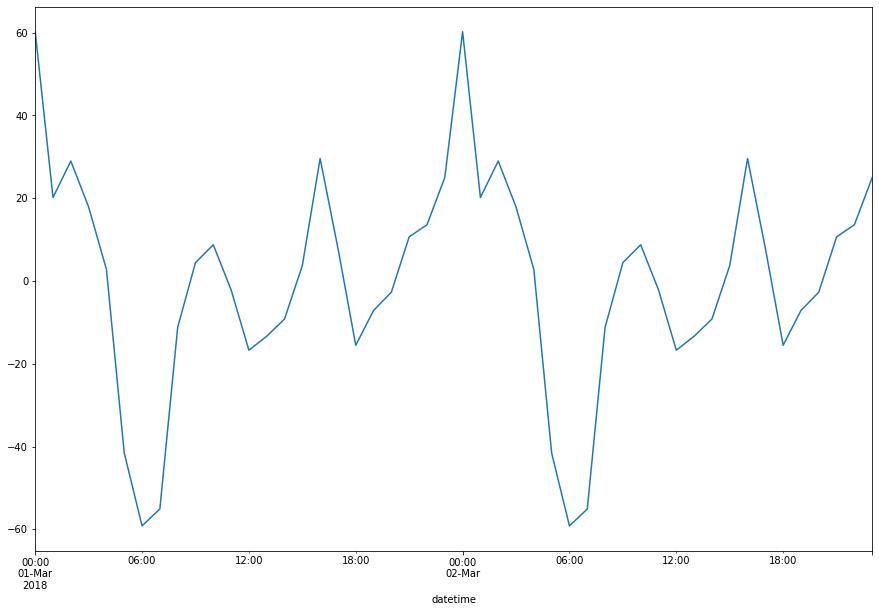

In [15]:
# посмторим на сезонность на отрезке в один день
decomposed.seasonal['2018-03-01':'2018-03-2'].plot(ax=plt.gca(), figsize = (15,10));

**Общий вывод**

Можем высказать осторожное предположение о намечающемся положительном тренде, а также уверенно утверждать о яркой внутрисуточной сезонности. Внутри одного дня есть три пика активности: начало рабочего дня, конец рабочего дня и около полуночи(когда все возвращаются из баров).

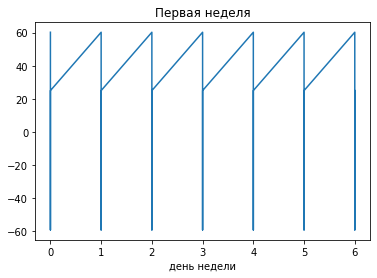

In [16]:
plt.plot(decomposed.seasonal['2018-03-05':'2018-03-11'].index.dayofweek,
            decomposed.seasonal['2018-03-05':'2018-03-11'].values);
plt.title('Первая неделя');
plt.xlabel('день недели');

## Обучение

### Подготовка данных

In [17]:
df = df.drop(['rolling_mean', 'rolling_std'],axis = 1)

In [18]:
# напишем функцию для создания признаков
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [19]:
# подберем отстающие значения, и размер скользящего окна
make_features(df, 3, 24)

In [20]:
# разделим данные на три выборки: обучающую, валидационную и тестовую в соотношении 80/10/10
train, test = train_test_split(df, shuffle=False, random_state = 12345, test_size=0.1)

In [21]:
train = train.dropna()

In [22]:
# соотношение выборок по объему
print(f"train = {100*len(train)/len(df):.2f}%")
print(f"test = {100*len(test)/len(df):.2f}%")

train = 89.45%
test = 10.01%


In [23]:
(features_train,
features_test) = (train.drop('num_orders',axis = 1),
                  test.drop('num_orders',axis = 1))
(target_train,
target_test) = (train['num_orders'],
                test['num_orders'])

Признаки созданы, выборки подготовлены, можем приступать к обучению.

### RandomForestRegressor

In [24]:
# TimeSeriesSplit
splits = TimeSeriesSplit(n_splits=8)

In [25]:
%%time

RFR = RandomForestRegressor(random_state=12345)
parametrs = {'max_depth': [1,10],'n_estimators': [100,150,10]}


def rmse(actual, predict):
    return mean_squared_error(actual, predict, squared=False)
custom_score = make_scorer(rmse, greater_is_better=False)
#custom_score = make_scorer(mean_squared_error, greater_is_better=False)
RFR_grid = GridSearchCV(RFR, parametrs, n_jobs=-1, cv=splits, scoring=custom_score)
RFR_grid.fit(features_train, target_train)

CPU times: user 15.7 s, sys: 98 ms, total: 15.8 s
Wall time: 15.9 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=RandomForestRegressor(random_state=12345), n_jobs=-1,
             param_grid={'max_depth': [1, 10], 'n_estimators': [100, 150, 10]},
             scoring=make_scorer(rmse, greater_is_better=False))

In [26]:
result_RFR = RFR_grid.best_score_
print(f"RandomForestRegressor: {result_RFR:.3f}")

RandomForestRegressor: -24.712


In [27]:
#predicted_valid_RFR = RFR_grid.predict(features_valid)
#result_RFR_valid = mean_squared_error(target_valid, predicted_valid_RFR, squared=False)
#print(f"RandomForestRegressor rmse: {result_RFR_valid:.3f}")

### CatBoostRegressor

In [28]:
%%time

CBR = CatBoostRegressor(loss_function='RMSE', random_state=12345, verbose=1000)
parameters_CBR = {'depth':[5,10], 'learning_rate':np.arange(0.1,1,0.2)}
CBR_grid = CBR.grid_search(parameters_CBR,
            Pool(features_train, target_train), cv=splits)

0:	learn: 72.7018459	test: 107.0056442	best: 107.0056442 (0)	total: 55.2ms	remaining: 55.2s
999:	learn: 12.0742721	test: 36.4404224	best: 33.4271790 (114)	total: 1.14s	remaining: 0us

bestTest = 33.427179
bestIteration = 114

0:	loss: 33.4271790	best: 33.4271790 (0)	total: 1.79s	remaining: 16.1s
0:	learn: 60.1592672	test: 92.0564017	best: 92.0564017 (0)	total: 1.19ms	remaining: 1.19s
999:	learn: 6.8018459	test: 39.1496969	best: 33.5889443 (36)	total: 1.14s	remaining: 0us

bestTest = 33.58894433
bestIteration = 36

1:	loss: 33.5889443	best: 33.4271790 (0)	total: 2.94s	remaining: 11.8s
0:	learn: 48.5852732	test: 77.7714714	best: 77.7714714 (0)	total: 1.56ms	remaining: 1.56s
999:	learn: 4.1044074	test: 42.1650434	best: 33.8136977 (21)	total: 1.09s	remaining: 0us

bestTest = 33.81369766
bestIteration = 21

2:	loss: 33.8136977	best: 33.4271790 (0)	total: 4.05s	remaining: 9.44s
0:	learn: 38.8552725	test: 64.5931075	best: 64.5931075 (0)	total: 4.98ms	remaining: 4.97s
999:	learn: 2.6081314	tes

In [29]:
CBR.best_score_

{'learn': {'RMSE': 13.471619704090143}}

In [30]:
#predicted_valid_CBR = CBR.predict(features_valid)
#result_CBR_valid = mean_squared_error(target_valid, predicted_valid_CBR, squared=False)
#print(f"CatBoostRegressor rmse: {result_CBR_valid:.3f}")

### LightGBM

In [33]:
%%time

# LightGBM
lgb_train = lgb.Dataset(features_train, target_train)
#lgb_valid = lgb.Dataset(features_valid, target_valid, reference=lgb_train)
parameters_LGBM = {'metric': 'rmse', 'max_depth':10,'random_state': 12345, 'learning_rate':0.1, 'verbose': -1}
LGBM = lgb.train(parameters_LGBM,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_train,
                verbose_eval=100)

/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	training's rmse: 16.4712
[200]	training's rmse: 14.23
[300]	training's rmse: 12.6542
[400]	training's rmse: 11.3634
[500]	training's rmse: 9.97269
[600]	training's rmse: 9.0819
[700]	training's rmse: 8.04595
[800]	training's rmse: 7.19172
[900]	training's rmse: 6.61564
[1000]	training's rmse: 6.11059
CPU times: user 32min 27s, sys: 34.3 s, total: 33min 2s
Wall time: 33min 10s


In [34]:
LGBM.best_score

defaultdict(collections.OrderedDict,
            {'training': OrderedDict([('rmse', 6.110587492462209)])})

In [ ]:
#predicted_valid_LGBM = LGBM.predict(features_valid)
#result_LGBM_valid = mean_squared_error(target_valid, predicted_valid_LGBM, squared=False)
#print(f"LGBMRegressor rmse: {result_LGBM_valid:.3f}")

In [38]:
# поместим полученный результаты в таблицу
# время в таблице – Wall time
compare = {
    'model':['RandomForestRegressor', 'CatBoostRegressor', 'LGBMRegressor',],
    'RMSE':[24.712,13.47,6.11],
    'learning time, s':[15.9,77,1990]}

In [39]:
pd.DataFrame(compare)

,model,RMSE,"learning time, s"
0,RandomForestRegressor,24.712,15.9
1,CatBoostRegressor,13.470,77.0
2,LGBMRegressor,6.110,1990.0


**Вывод**

Наша цель: значение метрики RMSE на тестовой выборке не больше 48.

Этого показателя достигли все модели, но лучший результат у **LGBMRegressor**. 

## Тестирование

In [37]:
predicted_test_LGBM = LGBM.predict(features_test)
result = mean_squared_error(target_test, predicted_test_LGBM, squared=False)
print(f"LGBMRegressor rmse: {result:.3f}")

LGBMRegressor rmse: 47.077


Тут же проверим модель на адекватность.

In [40]:
# предсказывать будем медиану

dummy_regr = DummyRegressor(strategy='median')
dummy_regr.fit(features_train, target_train)
predicted_test = dummy_regr.predict(features_test)

result = mean_squared_error(target_test, predicted_test, squared=False)
print(f"DummyRegressor rmse: {result:.3f}")

DummyRegressor rmse: 87.153


In [41]:
plot_comare = pd.DataFrame(target_test)
plot_comare['num_orders_rpedicted'] = predicted_test_LGBM

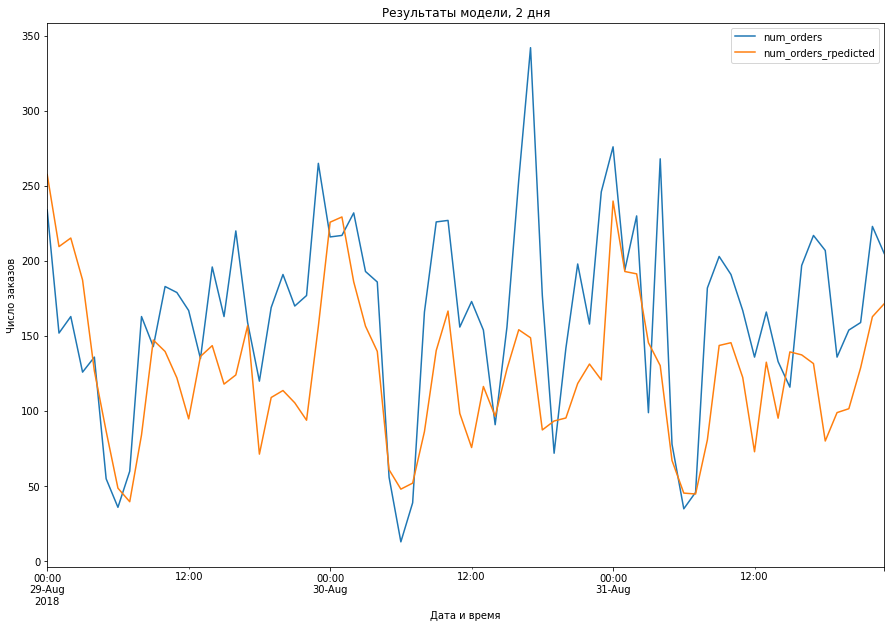

In [50]:
plot_comare['2018-08-29':'2018-08-31'].plot(figsize = (15,10));
plt.title('Результаты модели, 2 дня');
plt.xlabel('Дата и время');
plt.ylabel('Число заказов');

## Вывод

Работа содержит этапы:
* загрузка и подготовка данных
* анализ
* обучение трёх моделей с различными гиперпараметрами
* валидация лучшей модели

Целью было построить модель предсказания, чтобы значение метрики RMSE на тестовой выборке не превышало 48.
Таким критериям подходит модель **LGBMRegressor**, на тестовой выборке `RMSE = 47.077`, также пройден тест на адекватность.